In [ ]:
!pip -q install docling>=1.20.0 spacy>=3.7.0 conllu>=4.5.3 pandas>=2.2.0 tabulate>=0.9.0

In [ ]:
!python -m spacy download pt_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 1.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pt_core_news_lg

In [ ]:
from google.colab import files
import os
import pandas as pd
import re, json
from pathlib import Path
from typing import Dict, Any, List
from docling.document_converter import DocumentConverter

In [ ]:
import spacy
nlp = spacy.load('pt_core_news_lg')

In [ ]:
import inspect

In [ ]:
PDF_PATH = Path('/content/drive/MyDrive/IC/SIREVA/sireva_2023.pdf')
OUT_DIR = Path('/content/out'); OUT_DIR.mkdir(parents=True, exist_ok=True)
YEAR = 2023; SOURCE = 'SIREVA_SUS'
TABLE_DIR = OUT_DIR / 'tables' / str(YEAR); TABLE_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
print(TABLE_DIR)

/content/out/tables/2023


In [ ]:
converter = DocumentConverter()
conv_res = converter.convert(PDF_PATH.as_posix())
doc = conv_res.document

[INFO] 2025-11-09 01:00:51,717 [RapidOCR] base.py:22: Using engine_name: torch
[INFO] 2025-11-09 01:00:51,726 [RapidOCR] download_file.py:68: Initiating download: https://www.modelscope.cn/models/RapidAI/RapidOCR/resolve/v3.4.0/torch/PP-OCRv4/det/ch_PP-OCRv4_det_infer.pth
[INFO] 2025-11-09 01:00:53,202 [RapidOCR] download_file.py:82: Download size: 13.83MB
[INFO] 2025-11-09 01:00:53,632 [RapidOCR] download_file.py:95: Successfully saved to: /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_PP-OCRv4_det_infer.pth
[INFO] 2025-11-09 01:00:53,637 [RapidOCR] torch.py:54: Using /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_PP-OCRv4_det_infer.pth
[INFO] 2025-11-09 01:00:55,667 [RapidOCR] base.py:22: Using engine_name: torch
[INFO] 2025-11-09 01:00:55,669 [RapidOCR] download_file.py:68: Initiating download: https://www.modelscope.cn/models/RapidAI/RapidOCR/resolve/v3.4.0/torch/PP-OCRv4/cls/ch_ptocr_mobile_v2.0_cls_infer.pth
[INFO] 2025-11-09 01:00:56,890 [RapidOCR] downlo

In [ ]:
TABLE_MENTION_RE = re.compile(r"\b[Tt]abela[s]?\s+(\d+)\b")

In [ ]:
TABLE_MENTION_RE

re.compile(r'\b[Tt]abela[s]?\s+(\d+)\b', re.UNICODE)

In [ ]:
def to_conllu_sentence(sent, meta: Dict[str, Any]) -> str:
    """Tentando converter uma sentença spaCy em bloco CoNLL-U com MISC (Year, Source, Page, etc.)."""
    lines = []
    if 'sent_id' in meta: lines.append(f"# sent_id = {meta['sent_id']}")
    if 'text'   in meta: lines.append(f"# text = {meta['text']}")
    idx_map = {token.i: i+1 for i, token in enumerate(sent)}
    for i, token in enumerate(sent):
        ID    = i + 1
        FORM  = token.text
        LEMMA = token.lemma_ or '_'
        UPOS  = token.pos_ or '_'
        XPOS  = '_'
        feats = token.morph.to_dict()
        FEATS = '|'.join(f"{k}={v}" for k, v in feats.items()) if feats else '_'
        HEAD  = 0 if token.head.i == token.i else idx_map.get(token.head.i, 0)
        DEPREL= token.dep_ or '_'
        DEPS  = '_'
        misc  = {}
        for k in ('Year','Source','Page','ReportSection','TableRef'):
            if meta.get(k): misc[k] = str(meta[k])
        MISC = '|'.join(f"{k}={v}" for k,v in misc.items()) if misc else '_'
        lines.append('\t'.join(map(str,[ID,FORM,LEMMA,UPOS,XPOS,FEATS,str(HEAD),DEPREL,DEPS,MISC])))
    lines.append('')
    return '\n'.join(lines)

In [ ]:
def guess_section(text: str) -> str:
    t = text.lower()
    if 'introdução' in t: return 'Introducao'
    if 'método' in t or 'metodologia' in t: return 'Metodos'
    if 'resultados' in t: return 'Resultados'
    if 'discussão' in t: return 'Discussao'
    if 'conclus' in t: return 'Conclusao'
    return ''

In [ ]:
def _to_text(x):
    """Converte qualquer objeto (incl. métodos Docling) para string segura."""
    if callable(x):
        try:
            x = x()
        except TypeError:
            return str(x)
        except Exception:
            return str(x)
    if hasattr(x, "text"):
        try:
            return str(x.text)
        except Exception:
            pass
    try:
        return str(x)
    except Exception:
        return repr(x)

def _sanitize_seq(seq):
    """Sanitiza listas/tuplas aninhadas para tipos JSON (strings básicas)."""
    out = []
    for item in (seq or []):
        if isinstance(item, (list, tuple)):
            out.append(_sanitize_seq(item))
        else:
            out.append(_to_text(item))
    return out

def _sanitize_cols(cols_obj):
    """Extrai nomes de colunas de diferentes estruturas Docling/DataFrame."""
    cols = []
    if isinstance(cols_obj, (list, tuple)):
        for c in cols_obj:
            if hasattr(c, "name"):
                cols.append(_to_text(c.name))
            elif hasattr(c, "text"):
                cols.append(_to_text(c.text))
            else:
                cols.append(_to_text(c))
        return cols
    try:
        return [str(c) for c in list(cols_obj)]
    except Exception:
        return [_to_text(cols_obj)]

def _extract_table(table, table_id, doc):
    """Tenta extrair (cols, rows, caption) de uma tabela Docling, de forma robusta."""
    caption = getattr(table, "caption", "") or getattr(table, "caption_text", "")
    caption = _to_text(caption)

    try:
        df = table.export_to_dataframe(doc=doc)
        cols = _sanitize_cols(list(df.columns))
        rows = [[_to_text(v) for v in row] for row in df.fillna("").astype(str).values.tolist()]
        return cols, rows, caption
    except Exception as e:
        print(f"[Aviso] DataFrame falhou para {table_id}: {e}")

    cols, rows = [], []
    try:
        maybe_cols = getattr(table, "columns", [])
        if maybe_cols:
            cols = _sanitize_cols(maybe_cols)

        maybe_rows = getattr(table, "rows", []) or []
        tmp_rows = []
        for r in maybe_rows:
            if hasattr(r, "cells_text"):
                cells_txt = r.cells_text
                if callable(cells_txt):
                    try:
                        cells_txt = cells_txt()
                    except Exception:
                        pass
                if isinstance(cells_txt, (list, tuple)):
                    tmp_rows.append([_to_text(x) for x in cells_txt])
                else:
                    tmp_rows.append([_to_text(cells_txt)])
            elif hasattr(r, "cells") and r.cells:
                tmp_rows.append([_to_text(getattr(c, "text", c)) for c in r.cells])
            else:
                tmp_rows.append([_to_text(r)])
        rows = tmp_rows
        return cols, rows, caption
    except Exception as e2:
        print(f"[Aviso] Fallback textual falhou em {table_id}: {e2}")

    try:
        md = getattr(table, "to_markdown", None)
        if callable(md):
            sig = inspect.signature(getattr(table, "to_markdown"))
            md = md(doc=doc) if "doc" in sig.parameters else md()
        html = getattr(table, "to_html", None)
        if callable(html):
            sig = inspect.signature(getattr(table, "to_html"))
            html = html(doc=doc) if "doc" in sig.parameters else html()
        text_repr = _to_text(md or html or table)
        return [], [[text_repr]], caption
    except Exception:
        return [], [[_to_text(table)]], caption

In [ ]:
table_index: Dict[str, Dict[str, Any]] = {}
tables = getattr(doc, 'tables', []) or []
for ix, table in enumerate(tables):
    table_id = f"SIREVA_{YEAR}_t{ix+1:02d}"
    cols, rows, caption = _extract_table(table, table_id, doc)
    cols = _sanitize_seq(cols)
    rows = _sanitize_seq(rows)

    with open(TABLE_DIR / f"{table_id}.json", 'w', encoding='utf-8') as f:
        json.dump({'TableID': table_id, 'Caption': caption, 'Columns': cols, 'Rows': rows},
                  f, ensure_ascii=False, indent=2)
    table_index[table_id] = {'Caption': caption}

In [ ]:
conllu_blocks: List[str] = []
total_sent = 0
pages = getattr(doc, 'pages', []) or []
if not pages and hasattr(doc, 'export_to_text'):
    pages = [{'page_no':1, 'texts':[doc.export_to_text()]}]

In [ ]:
for p in pages:
    page_no = getattr(p, 'page_no', None) or getattr(p, 'pageNo', None) or 1

    texts = []
    children = getattr(p, 'children', []) or []
    for it in children:
        label = getattr(getattr(it, 'label', None), 'name', '').upper()
        if label in {'PARAGRAPH','TEXT','TITLE','SECTION_HEADER','LIST_ITEM'}:
            t = getattr(it, 'text', None) or getattr(it, 'caption_text', None) or ''
            if t: texts.append(t)

    if not texts and hasattr(doc, 'export_to_text'):
        texts = [doc.export_to_text()]

    for block in texts:
        block = block.strip()
        if not block:
            continue

        sect = guess_section(block[:160])
        d = nlp(block)

        for s_idx, sent in enumerate(d.sents, start=1):
            s_text = sent.text.strip()
            if not s_text:
                continue

            table_ref = None
            m = TABLE_MENTION_RE.search(s_text)
            if m:
                num = int(m.group(1))
                cand = f"SIREVA_{YEAR}_t{num:02d}"
                if cand in table_index:
                    table_ref = cand

            meta = {
                'sent_id': f"SIREVA_{YEAR}_p{int(page_no):02d}_s{s_idx:03d}",
                'text': s_text,
                'Year': YEAR,
                'Source': SOURCE,
                'Page': int(page_no)
            }
            if sect: meta['ReportSection'] = sect
            if table_ref: meta['TableRef'] = table_ref

            conllu_blocks.append(to_conllu_sentence(sent, meta))
            total_sent += 1

In [ ]:
(OUT_DIR / f'sireva_{YEAR}.conllu').write_text('\n'.join(conllu_blocks), encoding='utf-8')
(OUT_DIR / f'table_index_{YEAR}.json').write_text(json.dumps(table_index, ensure_ascii=False, indent=2), encoding='utf-8')

5037883

In [ ]:
print(f'Sentencas UD: {total_sent:,} | Tabelas: {len(table_index)}')

Sentencas UD: 96,191 | Tabelas: 57


In [ ]:
out = Path('/content/out')
conllu = out / 'sireva_2023.conllu'

In [ ]:
print('Mostrando as 60 primeiras linhas do CoNLL-U:')
print('\n'.join(conllu.read_text(encoding='utf-8').splitlines()[:60]))

Mostrando as 60 primeiras linhas do CoNLL-U:
# sent_id = SIREVA_2023_p01_s001
# text = ##
1	#	#	PROPN	_	Gender=Masc|Number=Sing	0	ROOT	_	Year=2023|Source=SIREVA_SUS|Page=1
2	#	#	PROPN	_	Number=Sing	1	punct	_	Year=2023|Source=SIREVA_SUS|Page=1

# sent_id = SIREVA_2023_p01_s002
# text = SECRETARIA DE ESTADO DA SAÚDE COORDENADORIA DE CONTROLE DE DOENÇAS
1	SECRETARIA	SECRETARIA	PROPN	_	Gender=Fem|Number=Sing	0	ROOT	_	Year=2023|Source=SIREVA_SUS|Page=1
2	DE	DE	ADP	_	_	3	case	_	Year=2023|Source=SIREVA_SUS|Page=1
3	ESTADO	eSTADO	NOUN	_	Gender=Masc|Number=Sing	1	nmod	_	Year=2023|Source=SIREVA_SUS|Page=1
4	DA	de o	ADP	_	Definite=Def|Gender=Fem|Number=Sing|PronType=Art	5	case	_	Year=2023|Source=SIREVA_SUS|Page=1
5	SAÚDE	SAÚDE	PROPN	_	Gender=Fem|Number=Sing	1	nmod	_	Year=2023|Source=SIREVA_SUS|Page=1
6	COORDENADORIA	COORDENADORIA	PROPN	_	Number=Sing	5	flat:name	_	Year=2023|Source=SIREVA_SUS|Page=1
7	DE	DE	PROPN	_	Number=Sing	8	case	_	Year=2023|Source=SIREVA_SUS|Page=1
8	CONTROLE	CONTROLE	PROPN	_	

In [ ]:
print('\nArquivos de tabelas (até 10):')
tables_dir = out / 'tables' / '2023'
print(sorted([p.name for p in tables_dir.glob('*.json')])[:10])


Arquivos de tabelas (até 10):
['SIREVA_2023_t01.json', 'SIREVA_2023_t02.json', 'SIREVA_2023_t03.json', 'SIREVA_2023_t04.json', 'SIREVA_2023_t05.json', 'SIREVA_2023_t06.json', 'SIREVA_2023_t07.json', 'SIREVA_2023_t08.json', 'SIREVA_2023_t09.json', 'SIREVA_2023_t10.json']


# Verificando

In [ ]:
from collections import Counter, defaultdict

In [ ]:
conllu_path = Path("/content/out/sireva_2023.conllu")
print(conllu_path)

/content/out/sireva_2023.conllu


In [ ]:
UD_UPOS = {
    "ADJ","ADP","ADV","AUX","CCONJ","DET","INTJ","NOUN","NUM","PART",
    "PRON","PROPN","PUNCT","SCONJ","SYM","VERB","X"
}
UD_DEPREL = {
    "acl","advcl","advmod","amod","appos","aux","case","cc","ccomp","clf","compound",
    "conj","cop","csubj","dep","det","discourse","dislocated","expl","fixed","flat",
    "goeswith","iobj","list","mark","nmod","nsubj","nummod","obj","obl","orphan",
    "parataxis","punct","reparandum","root","vocative","xcomp",
    "aux:pass","flat:name","nmod:poss","nmod:tmod","obl:agent","obl:tmod","compound:prt"
}

In [ ]:
def parse_sentences(path):
    """Gera sentencas como blocos (linhas), preservando comentários # e tokens."""
    with path.open("r", encoding="utf-8") as f:
        buf = []
        for line in f:
            line = line.rstrip("\n")
            if not line:
                if buf:
                    yield buf
                    buf = []
            else:
                buf.append(line)
        if buf:
            yield buf

In [ ]:
errors = []
sent_count = 0
tok_count = 0

In [ ]:
misc_has_year = 0
misc_has_source = 0
misc_has_page = 0
misc_has_tableref = 0

In [ ]:
sections = Counter()
upos_counter = Counter()
deprel_counter = Counter()

In [ ]:
def check_token_cols(cols, sent_id, lineno):
    if len(cols) != 10:
        errors.append((sent_id, lineno, f"Esperado 10 colunas, encontrei {len(cols)}"))
        return False
    return True

In [ ]:
def check_ids_and_heads(tokens, sent_id):

    ids = []
    root_count = 0
    for t in tokens:
        if isinstance(t["id"], int):
            ids.append(t["id"])

        if t["head"] == 0:
            root_count += 1

    if ids and (sorted(ids) != list(range(1, max(ids) + 1))):
        errors.append((sent_id, None, f"IDs não consecutivos: {ids[:10]}..."))

    if root_count != 1:
        errors.append((sent_id, None, f"Root(s) na sentença: {root_count}"))

    max_id = max(ids) if ids else 0
    for t in tokens:
        h = t["head"]
        if not (0 <= h <= max_id):
            errors.append((sent_id, None, f"HEAD fora do intervalo [0,{max_id}]: {h}"))

In [ ]:
for block in parse_sentences(conllu_path):
    sent_id = None
    text = None
    tokens = []
    local_line = 0
    misc_section = ""

    for line in block:
        local_line += 1
        if line.startswith("#"):
            if line.startswith("# sent_id"):
                sent_id = line.split("=",1)[1].strip()
            elif line.startswith("# text"):
                text = line.split("=",1)[1].strip()
            continue

        cols = line.split("\t")
        if not check_token_cols(cols, sent_id, local_line):
            continue

        ID, FORM, LEMMA, UPOS, XPOS, FEATS, HEAD, DEPREL, DEPS, MISC = cols

        if "-" in ID or "." in ID:
            continue

        try:
            tid = int(ID)
        except Exception:
            errors.append((sent_id, local_line, f"ID não inteiro: {ID}"))
            continue

        try:
            head = int(HEAD)
        except Exception:
            errors.append((sent_id, local_line, f"HEAD não inteiro: {HEAD}"))
            head = 0

        upos_counter[UPOS] += 1
        if UPOS not in UD_UPOS:
            errors.append((sent_id, local_line, f"UPOS fora do UD v2: {UPOS}"))

        deprel_counter[DEPREL] += 1
        base_deprel = DEPREL.split(":")[0]
        if base_deprel not in UD_DEPREL:
            errors.append((sent_id, local_line, f"DEPREL fora do UD v2: {DEPREL}"))

        has_year = "Year=" in MISC
        has_source = "Source=" in MISC
        has_page = "Page=" in MISC
        has_tableref = "TableRef=" in MISC
        if has_year: misc_has_year += 1
        if has_source: misc_has_source += 1
        if has_page: misc_has_page += 1
        if has_tableref: misc_has_tableref += 1

        msec = re.search(r"ReportSection=([A-Za-z]+)", MISC)
        if msec:
            sections[msec.group(1)] += 1

        tokens.append(dict(id=tid, head=head, upos=UPOS, deprel=DEPREL, misc=MISC))
        tok_count += 1

    sent_count += 1
    if tokens:
        check_ids_and_heads(tokens, sent_id)

In [ ]:
print("Validação estrutural concluída.\n")
print(f"Sentencas: {sent_count:,}")
print(f"Tokens: {tok_count:,}\n")

Validação estrutural concluída.

Sentenças: 117,003
Tokens: 1,237,411



In [ ]:
print("Metadados em MISC (contagem de tokens com o campo):")
print(f"Year= {misc_has_year:,}")
print(f"Source= {misc_has_source:,}")
print(f"Page= {misc_has_page:,}")
print(f"TableRef= {misc_has_tableref:,} (relevante para frases que citam tabelas)\n")

Metadados em MISC (contagem de tokens com o campo):
Year= 1,237,411
Source= 1,237,411
Page= 1,237,411
TableRef= 5,848 (relevante para frases que citam tabelas)



In [ ]:
print("Distribuicao por ReportSection (tokens):")
for k,v in sections.most_common():
    print(f"  {k:12s} {v:,}")
print()

Distribuicao por ReportSection (tokens):



In [ ]:
unk_upos = [u for u in upos_counter if u not in UD_UPOS]
unk_deprel = [d for d in deprel_counter if d.split(':')[0] not in UD_DEPREL]

In [ ]:
print(unk_upos)

['SPACE']


In [ ]:
print(f"UPOS distintos: {len(upos_counter)}; fora do UD: {len(unk_upos)}")
if unk_upos:
    print("  Exemplos UPOS fora do UD:", unk_upos[:10])

UPOS distintos: 15; fora do UD: 1
  Exemplos UPOS fora do UD: ['SPACE']


In [ ]:
print(f"DEPREL distintos: {len(deprel_counter)}; fora do UD: {len(unk_deprel)}")
if unk_deprel:
    print("  Exemplos DEPREL fora do UD:", unk_deprel[:10])

DEPREL distintos: 31; fora do UD: 1
  Exemplos DEPREL fora do UD: ['ROOT']


In [ ]:
print(f"\nTotal de problemas encontrados: {len(errors):,}")
if errors:
    print("\nAmostras de problemas (máx. 25):")
    for sid, ln, msg in errors[:25]:
        ref = f"{sid or 'SENT'}:{ln or '?'}"
        print(f"  - {ref} → {msg}")


Total de problemas encontrados: 665,984

Amostras de problemas (máx. 25):
  - SIREVA_2023_p01_s001:3 → DEPREL fora do UD v2: ROOT
  - SIREVA_2023_p01_s002:3 → DEPREL fora do UD v2: ROOT
  - SENT:2 → DEPREL fora do UD v2: ROOT
  - SENT:5 → Esperado 10 colunas, encontrei 2
  - SENT:1 → Esperado 10 colunas, encontrei 2
  - SENT:1 → Esperado 10 colunas, encontrei 8
  - SENT:? → IDs não consecutivos: [5, 6]...
  - SENT:? → Root(s) na sentença: 0
  - SENT:1 → Esperado 10 colunas, encontrei 1
  - SENT:1 → Esperado 10 colunas, encontrei 1
  - SENT:2 → DEPREL fora do UD v2: ROOT
  - SENT:10 → Esperado 10 colunas, encontrei 2
  - SENT:1 → Esperado 10 colunas, encontrei 2
  - SENT:1 → Esperado 10 colunas, encontrei 8
  - SENT:3 → Esperado 10 colunas, encontrei 2
  - SENT:? → IDs não consecutivos: [10]...
  - SENT:? → Root(s) na sentença: 0
  - SENT:1 → Esperado 10 colunas, encontrei 2
  - SENT:1 → Esperado 10 colunas, encontrei 8
  - SENT:? → IDs não consecutivos: [12]...
  - SENT:? → Root(s) na

# Tentativa de Visualizacao

In [ ]:
import re, random
from conllu import parse_incr
import spacy
from spacy import displacy

In [ ]:
raw_path = Path("/content/out/sireva_2023.conllu")
clean_path = Path("/content/out/sireva_2023_clean.conllu")

In [ ]:
def quick_clean_to_tmp(src: Path, dst: Path):
    """Limpeza leve: remove tokens SPACE, corrige ROOT->root e garante 10 colunas."""
    import re
    raw = src.read_text(encoding="utf-8").splitlines()
    out = []
    for line in raw:
        if not line.strip():
            out.append("")
            continue
        if line.startswith("#"):
            out.append(line)
            continue
        if "\t" not in line:
            continue
        line = line.replace("\tROOT\t", "\troot\t")
        if "\tSPACE\t" in line:
            continue
        parts = line.split("\t")
        if len(parts) < 10:
            continue
        if len(parts) > 10:
            parts = parts[:10]
        out.append("\t".join(parts))
    dst.write_text("\n".join(out), encoding="utf-8")

In [ ]:
if not clean_path.exists():
    print("Gerando limpeza leve temporária para visualizacao")
    quick_clean_to_tmp(raw_path, clean_path)

Gerando limpeza leve temporária para visualizacao


In [ ]:
sents = []
with open(clean_path, encoding="utf-8") as f:
    for tokenlist in parse_incr(f):
        txt = tokenlist.metadata.get("text")
        if not txt:
            forms = [t["form"] for t in tokenlist if isinstance(t["id"], int)]
            txt = " ".join(forms).strip()
        if txt:
            sents.append(txt)

In [ ]:
print(f"Sentencas carregadas: {len(sents):,}")

Sentencas carregadas: 148,006


In [ ]:
alvo = [
    s for s in sents
    if re.search(r"streptococcus\s+pneumoniae", s, flags=re.I)
]
if not alvo:
    padroes = [
        r"S\.\s*pneumoniae",
        r"pneumoc[oô]co",
        r"meningitidis",
        r"Haemophilus\s+influenzae",
    ]
    for pat in padroes:
        alvo = [s for s in sents if re.search(pat, s, flags=re.I)]
        if alvo:
            break

In [ ]:
if not alvo:
    alvo = [s for s in sents if len(s.split()) >= 8]

sample_text = random.choice(alvo) if alvo else sents[0]
print("Frase selecionada:\n", sample_text)

Frase selecionada:
 Streptococcus pneumoniae ..........................................................................


In [ ]:
doc = nlp(sample_text)
displacy.render(doc, style="dep", jupyter=True)

# Arvore

In [ ]:
from spacy import displacy
from IPython.display import SVG, display

In [ ]:
options = {
    "compact": False,
    "color": "#000000",
    "bg": "#FFFFFF",
    "distance": 140,
    "add_lemma": False,
    "collapse_punct": False,
    "collapse_phrases": False
}

In [ ]:
clean_path = Path("/content/out/sireva_2023_clean.conllu")

sents = []
with open(clean_path, encoding="utf-8") as f:
    for tokenlist in parse_incr(f):
        txt = tokenlist.metadata.get("text")
        if not txt:
            forms = [t["form"] for t in tokenlist if isinstance(t["id"], int)]
            txt = " ".join(forms).strip()
        if txt and len(txt.split()) >= 8:
            sents.append(txt)

Frase selecionada: Nesse  contexto,  o  IAL monitora as características fenotípicas e moleculares dos isolados de Neisseria meningitidis ,


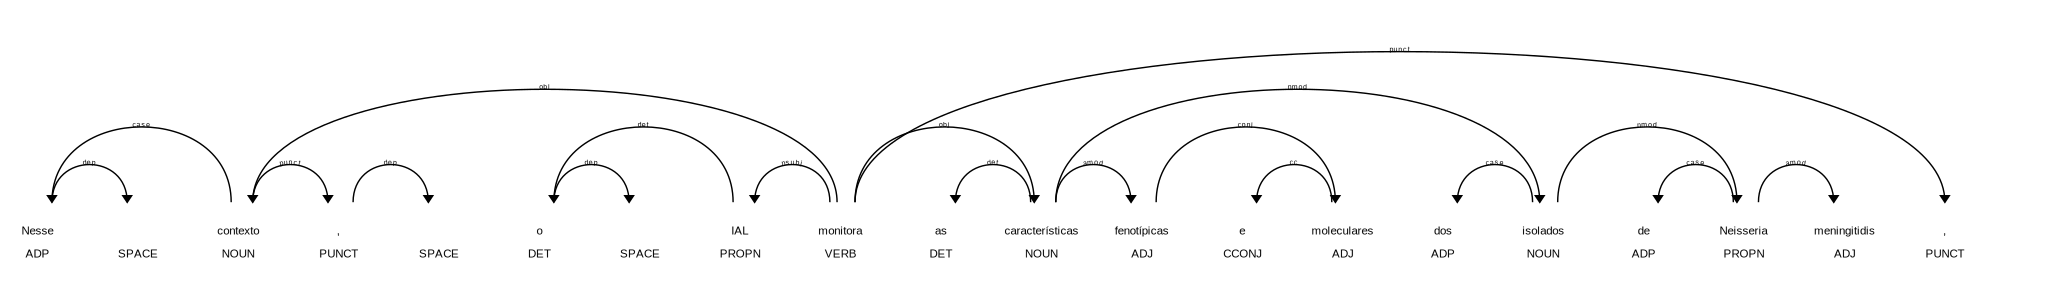

SVG salvo em: /content/ud_sireva_exemplo.svg


In [ ]:
candidatas = [s for s in sents if re.search(r"Streptococcus\s+pneumoniae|Haemophilus\s+influenzae|meningitidis", s, flags=re.I)]
sent = candidatas[0] if candidatas else sents[0]
print("Frase selecionada:", sent)

doc = nlp(sent)
svg = displacy.render(doc, style="dep", options=options, jupyter=False)
out_svg = "/content/ud_sireva_exemplo.svg"
with open(out_svg, "w", encoding="utf-8") as f:
    f.write(svg)

display(SVG(svg))
print(f"SVG salvo em: {out_svg}")